# Interpretable AI Project

Saul Vassallo and David Scerri

In [21]:
# TensorFlow
import tensorflow as tf
from tensorflow import keras
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Commonly used modules
import numpy as np

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import IPython
from six.moves import urllib

from pdpbox import pdp

print(tf.__version__)

2.18.0


## Boston Housing Model

Load the data

In [22]:
(boston_train_features, boston_train_labels), (boston_test_features, boston_test_labels) = keras.datasets.boston_housing.load_data()

print(boston_train_features.shape)
print(boston_test_features.shape)
print(boston_train_labels.shape)
print(boston_test_labels.shape)

(404, 13)
(102, 13)
(404,)
(102,)


Add the labels back to the dataset for feature engineering

- CRIM - per capita crime rate by town
- ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS - proportion of non-retail business acres per town.
- CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX - nitric oxides concentration (parts per 10 million)
- RM - average number of rooms per dwelling
- AGE - proportion of owner-occupied units built prior to 1940
- DIS - weighted distances to five Boston employment centres
- RAD - index of accessibility to radial highways
- TAX - full-value property-tax rate per $10,000
- PTRATIO - pupil-teacher ratio by town
- B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT - % lower status of the population
  
- MEDV - Median value of owner-occupied homes in $1000's



In [23]:
boston_feature_names = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 
    'RM', 'AGE', 'DIS', 'RAD', 'TAX', 
    'PTRATIO', 'B', 'LSTAT'
]

boston_train_features_df = pd.DataFrame(boston_train_features, columns=boston_feature_names)
boston_test_features_df = pd.DataFrame(boston_test_features, columns=boston_feature_names)

print("Training Dataset Shape:", boston_train_features_df.shape)
print("\nFirst few rows of training data:")
print(boston_train_features_df.head())
print("\nDataset Info:")
print(boston_train_features_df.describe())

Training Dataset Shape: (404, 13)

First few rows of training data:
      CRIM    ZN  INDUS  CHAS    NOX     RM    AGE     DIS   RAD    TAX  \
0  1.23247   0.0   8.14   0.0  0.538  6.142   91.7  3.9769   4.0  307.0   
1  0.02177  82.5   2.03   0.0  0.415  7.610   15.7  6.2700   2.0  348.0   
2  4.89822   0.0  18.10   0.0  0.631  4.970  100.0  1.3325  24.0  666.0   
3  0.03961   0.0   5.19   0.0  0.515  6.037   34.5  5.9853   5.0  224.0   
4  3.69311   0.0  18.10   0.0  0.713  6.376   88.4  2.5671  24.0  666.0   

   PTRATIO       B  LSTAT  
0     21.0  396.90  18.72  
1     14.7  395.38   3.11  
2     20.2  375.52   3.26  
3     20.2  396.90   8.01  
4     20.2  391.43  14.65  

Dataset Info:
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  404.000000  404.000000  404.000000  404.000000  404.000000  404.000000   
mean     3.745111   11.480198   11.104431    0.061881    0.557356    6.267082   
std      9.240734   23.767711    6.811308    0.241238  

Scale non categorical inputs (RAD) and outputs using Z-Score

In [24]:
def z_score_scale(data, columns_to_scale=None, exclude_columns=None):
    """
    Scales columns using sklearn's StandardScaler. Can either specify columns to scale
    or columns to exclude from scaling.
    
    Args:
        data: pandas DataFrame containing the data
        columns_to_scale: list of column names to scale (optional)
        exclude_columns: list of column names to exclude from scaling (optional)
    
    Returns:
        DataFrame with scaled columns
    
    Note:
        If columns_to_scale is provided, exclude_columns is ignored.
        If neither is provided, all columns are scaled.
    """
    scaled_data = data.copy()
    
    # Determine which columns to scale
    if columns_to_scale is not None:
        # Use specified columns
        columns_to_process = columns_to_scale
    else:
        # Use all columns except excluded ones
        exclude_columns = exclude_columns or []
        columns_to_process = [col for col in data.columns if col not in exclude_columns]
    
    scaler = StandardScaler()
    scaled_data[columns_to_process] = scaler.fit_transform(data[columns_to_process])
    return scaled_data

boston_train_features_scaled_df = z_score_scale(boston_train_features_df, exclude_columns=['CHAS'])
boston_test_features_scaled_df = z_score_scale(boston_test_features_df, exclude_columns=['CHAS'])

scaler = StandardScaler()
boston_train_labels_scaled = scaler.fit_transform(boston_train_labels.reshape(-1, 1))
boston_test_labels_scaled = scaler.fit_transform(boston_test_labels.reshape(-1, 1))

boston_test_df = pd.concat([boston_test_features_scaled_df, pd.DataFrame(boston_test_labels_scaled, columns=['MEDV'])], axis=1)

print(boston_train_features_scaled_df.head())
print(boston_test_features_scaled_df.head())


       CRIM        ZN     INDUS  CHAS       NOX        RM       AGE       DIS  \
0 -0.272246 -0.483615 -0.435762   0.0 -0.165227 -0.176443  0.813062  0.116698   
1 -0.403427  2.991784 -1.333912   0.0 -1.215182  1.894346 -1.910361  1.247585   
2  0.124940 -0.483615  1.028326   0.0  0.628642 -1.829688  1.110488 -1.187439   
3 -0.401494 -0.483615 -0.869402   0.0 -0.361560 -0.324558 -1.236672  1.107180   
4 -0.005634 -0.483615  1.028326   0.0  1.328612  0.153642  0.694808 -0.578572   

        RAD       TAX   PTRATIO         B     LSTAT  
0 -0.626249 -0.595170  1.148500  0.448077  0.825220  
1 -0.856463 -0.348433 -1.718189  0.431906 -1.329202  
2  1.675886  1.565287  0.784476  0.220617 -1.308500  
3 -0.511142 -1.094663  0.784476  0.448077 -0.652926  
4  1.675886  1.565287  0.784476  0.389882  0.263497  
       CRIM        ZN     INDUS  CHAS       NOX        RM       AGE       DIS  \
0  2.804030 -0.507849  0.969609   0.0  1.231746  0.119341  1.147398 -0.919353   
1 -0.555306 -0.507849 -0.17

Epoch 1/10000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6004 - mae: 0.8349 - mse: 1.6004 - val_loss: 0.5996 - val_mae: 0.5504 - val_mse: 0.5996
Epoch 2/10000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2499 - mae: 0.7062 - mse: 1.2499 - val_loss: 0.4452 - val_mae: 0.4892 - val_mse: 0.4452
Epoch 3/10000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9877 - mae: 0.6242 - mse: 0.9877 - val_loss: 0.3353 - val_mae: 0.4326 - val_mse: 0.3353
Epoch 4/10000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8053 - mae: 0.5819 - mse: 0.8053 - val_loss: 0.2653 - val_mae: 0.3963 - val_mse: 0.2653
Epoch 5/10000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6756 - mae: 0.5464 - mse: 0.6756 - val_loss: 0.2234 - val_mae: 0.3719 - val_mse: 0.2234
Epoch 6/10000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6592 - mae: 0.5263 - mse: 0.6592 - val_loss: 0.1930 - val_mae: 0.3521 - val_mse: 0.1930
Epoch 7/10000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5266 - mae: 0.4981 - mse: 0.526

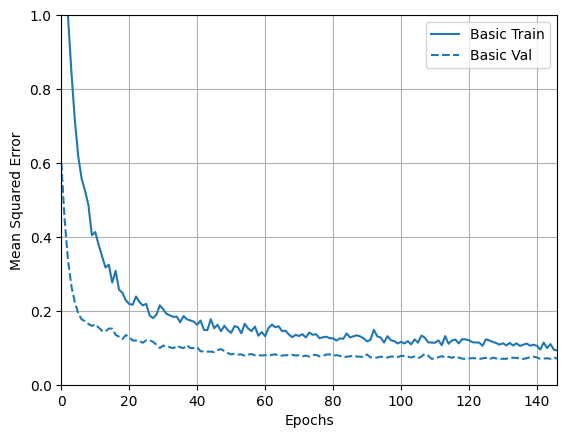

In [25]:
boston_model = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(13,)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1)
])

boston_model.compile(optimizer='adam',
                     loss='mse',
                     metrics=['mse', 'mae'])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = boston_model.fit(boston_train_features_scaled_df, boston_train_labels_scaled, epochs=10000, validation_split=0.1, callbacks=[early_stop])

plotter = tfdocs.plots.HistoryPlotter(metric = 'mse')
plotter.plot({'Basic': history}, metric = 'mse')
plt.ylim([0, 1])
plt.ylabel('Mean Squared Error')
plt.show()


## Titanic Model

load data and check nu of nas and na percentages


In [26]:
titanic_train_data = pd.read_csv('data/titanic/train.csv')
titanic_test_data = pd.read_csv('data/titanic/test.csv')

print(titanic_train_data.shape)
print(titanic_test_data.shape)

# Check NA values in training data
print("NA values in training data:")
print(titanic_train_data.isna().sum())

print("\nNA values in test data:")
print(titanic_test_data.isna().sum())

# Percentage of NA values in training data
print("\nPercentage of NA values in training data:")
print((titanic_train_data.isna().sum() / len(titanic_train_data)) * 100)

print("\nPercentage of NA values in test data:")
print((titanic_test_data.isna().sum() / len(titanic_test_data)) * 100)

print(titanic_train_data.head())
print(titanic_test_data.head())


(891, 12)
(418, 11)
NA values in training data:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

NA values in test data:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Percentage of NA values in training data:
PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

Percentage of NA values in test data:
PassengerId     0.000000
Pclass          0.000000
Name            0

Drop non-numerical columns

In [27]:
# Feature engineering

# Drop unnecessary columns
titanic_train_data = titanic_train_data.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId'])
titanic_test_data = titanic_test_data.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId'])

print(titanic_train_data.head())
print(titanic_test_data.head())


   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0         0       3    male  22.0      1      0   7.2500        S
1         1       1  female  38.0      1      0  71.2833        C
2         1       3  female  26.0      0      0   7.9250        S
3         1       1  female  35.0      1      0  53.1000        S
4         0       3    male  35.0      0      0   8.0500        S
   Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0       3    male  34.5      0      0   7.8292        Q
1       3  female  47.0      1      0   7.0000        S
2       2    male  62.0      0      0   9.6875        Q
3       3    male  27.0      0      0   8.6625        S
4       3  female  22.0      1      1  12.2875        S


Encode categorical columns

In [28]:
def encode_features(data):
    mappings = {}
    for column in data.columns:
        if data[column].dtype == 'object':
            le = LabelEncoder()
            data[column] = le.fit_transform(data[column])
            # Store the mapping
            mappings[column] = dict(zip(le.classes_, le.transform(le.classes_)))
            print(f"\nMapping for {column}:")
            for original, encoded in mappings[column].items():
                print(f"{original} → {encoded}")
    return data

titanic_train_data = encode_features(titanic_train_data)
titanic_test_data = encode_features(titanic_test_data)


print(titanic_train_data.head())
print(titanic_test_data.head())


Mapping for Sex:
female → 0
male → 1

Mapping for Embarked:
C → 0
Q → 1
S → 2
nan → 3

Mapping for Sex:
female → 0
male → 1

Mapping for Embarked:
C → 0
Q → 1
S → 2
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0         0       3    1  22.0      1      0   7.2500         2
1         1       1    0  38.0      1      0  71.2833         0
2         1       3    0  26.0      0      0   7.9250         2
3         1       1    0  35.0      1      0  53.1000         2
4         0       3    1  35.0      0      0   8.0500         2
   Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0       3    1  34.5      0      0   7.8292         1
1       3    0  47.0      1      0   7.0000         2
2       2    1  62.0      0      0   9.6875         1
3       3    1  27.0      0      0   8.6625         2
4       3    0  22.0      1      1  12.2875         2


Deal with NA values by replacing them with their means and dropping the 2 in embarked col

In [29]:
titanic_train_data = titanic_train_data[titanic_train_data['Embarked'] != 3]

titanic_train_data = titanic_train_data.fillna(titanic_train_data.mean())
titanic_test_data = titanic_test_data.fillna(titanic_test_data.mean())

Scale non-categorical values using z-score

In [30]:
titanic_train_data = z_score_scale(titanic_train_data, ['Age', 'Fare', 'SibSp', 'Parch'])
titanic_test_data = z_score_scale(titanic_test_data, ['Age', 'Fare', 'SibSp', 'Parch'])

print(titanic_train_data.head())## #########assadsadaaajfjsf
print(titanic_test_data.head())

   Survived  Pclass  Sex       Age     SibSp     Parch      Fare  Embarked
0         0       3    1 -0.589620  0.431350 -0.474326 -0.500240         2
1         1       1    0  0.644848  0.431350 -0.474326  0.788947         0
2         1       3    0 -0.281003 -0.475199 -0.474326 -0.486650         2
3         1       1    0  0.413385  0.431350 -0.474326  0.422861         2
4         0       3    1  0.413385 -0.475199 -0.474326 -0.484133         2
   Pclass  Sex       Age     SibSp     Parch      Fare  Embarked
0       3    1  0.334993 -0.499470 -0.400248 -0.498407         1
1       3    0  1.325530  0.616992 -0.400248 -0.513274         2
2       2    1  2.514175 -0.499470 -0.400248 -0.465088         1
3       3    1 -0.259330 -0.499470 -0.400248 -0.483466         2
4       3    0 -0.655545  0.616992  0.619896 -0.418471         2


Separate labels and features for training

In [31]:
titanic_train_features = titanic_train_data.drop(columns=['Survived'])
titanic_train_labels = titanic_train_data['Survived']

titanic_test_features = titanic_test_data

Train the Model

Epoch 1/10000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6457 - loss: 0.6125 - val_accuracy: 0.6742 - val_loss: 0.5770
Epoch 2/10000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6818 - loss: 0.5834 - val_accuracy: 0.6742 - val_loss: 0.5544
Epoch 3/10000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7000 - loss: 0.5564 - val_accuracy: 0.7079 - val_loss: 0.5350
Epoch 4/10000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7138 - loss: 0.5487 - val_accuracy: 0.7416 - val_loss: 0.5179
Epoch 5/10000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7153 - loss: 0.5660 - val_accuracy: 0.7640 - val_loss: 0.5061
Epoch 6/10000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7632 - loss: 0.5243 - val_accuracy: 0.7753 - val_loss: 0.4928
Epoch 7/10000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7863 - loss: 0.4862 - val_accuracy: 0.7978 - val_loss: 0.4844
Epoch 8/10000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7428 - loss: 0.5323 - val_accu

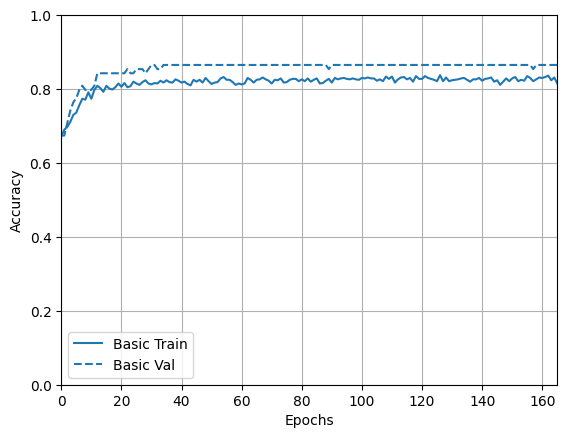

In [32]:
titanic_model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

titanic_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

history = titanic_model.fit(titanic_train_features, titanic_train_labels, epochs=10000, validation_split=0.1, callbacks=[early_stop])

plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot({'Basic': history}, metric = 'accuracy')
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.show()

### Cifar-10 Model

Load CIFAR-10 Dataset and Preprocess

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

Define CNN Architecture

In [ ]:
cnn_model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    keras.layers.MaxPooling2D((2,2)),

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),

    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')  # 10 classes for CIFAR-10
])

cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

Train the Model

In [ ]:
history = cnn_model.fit(x_train, y_train, epochs=10000, validation_split=0.1, batch_size=64, callbacks=[early_stop])

plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot({'Basic': history}, metric = 'accuracy')
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.show()

## Part 1: Feature Level Interpretability

### 1.1 Boston

obtain pred_func from the provided model.


  0%|          | 0/8 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 12%|█▎        | 1/8 [00:00<00:00,  9.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 50%|█████     | 4/8 [00:00<00:00, 21.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


100%|██████████| 8/8 [00:00<00:00, 23.86it/s]


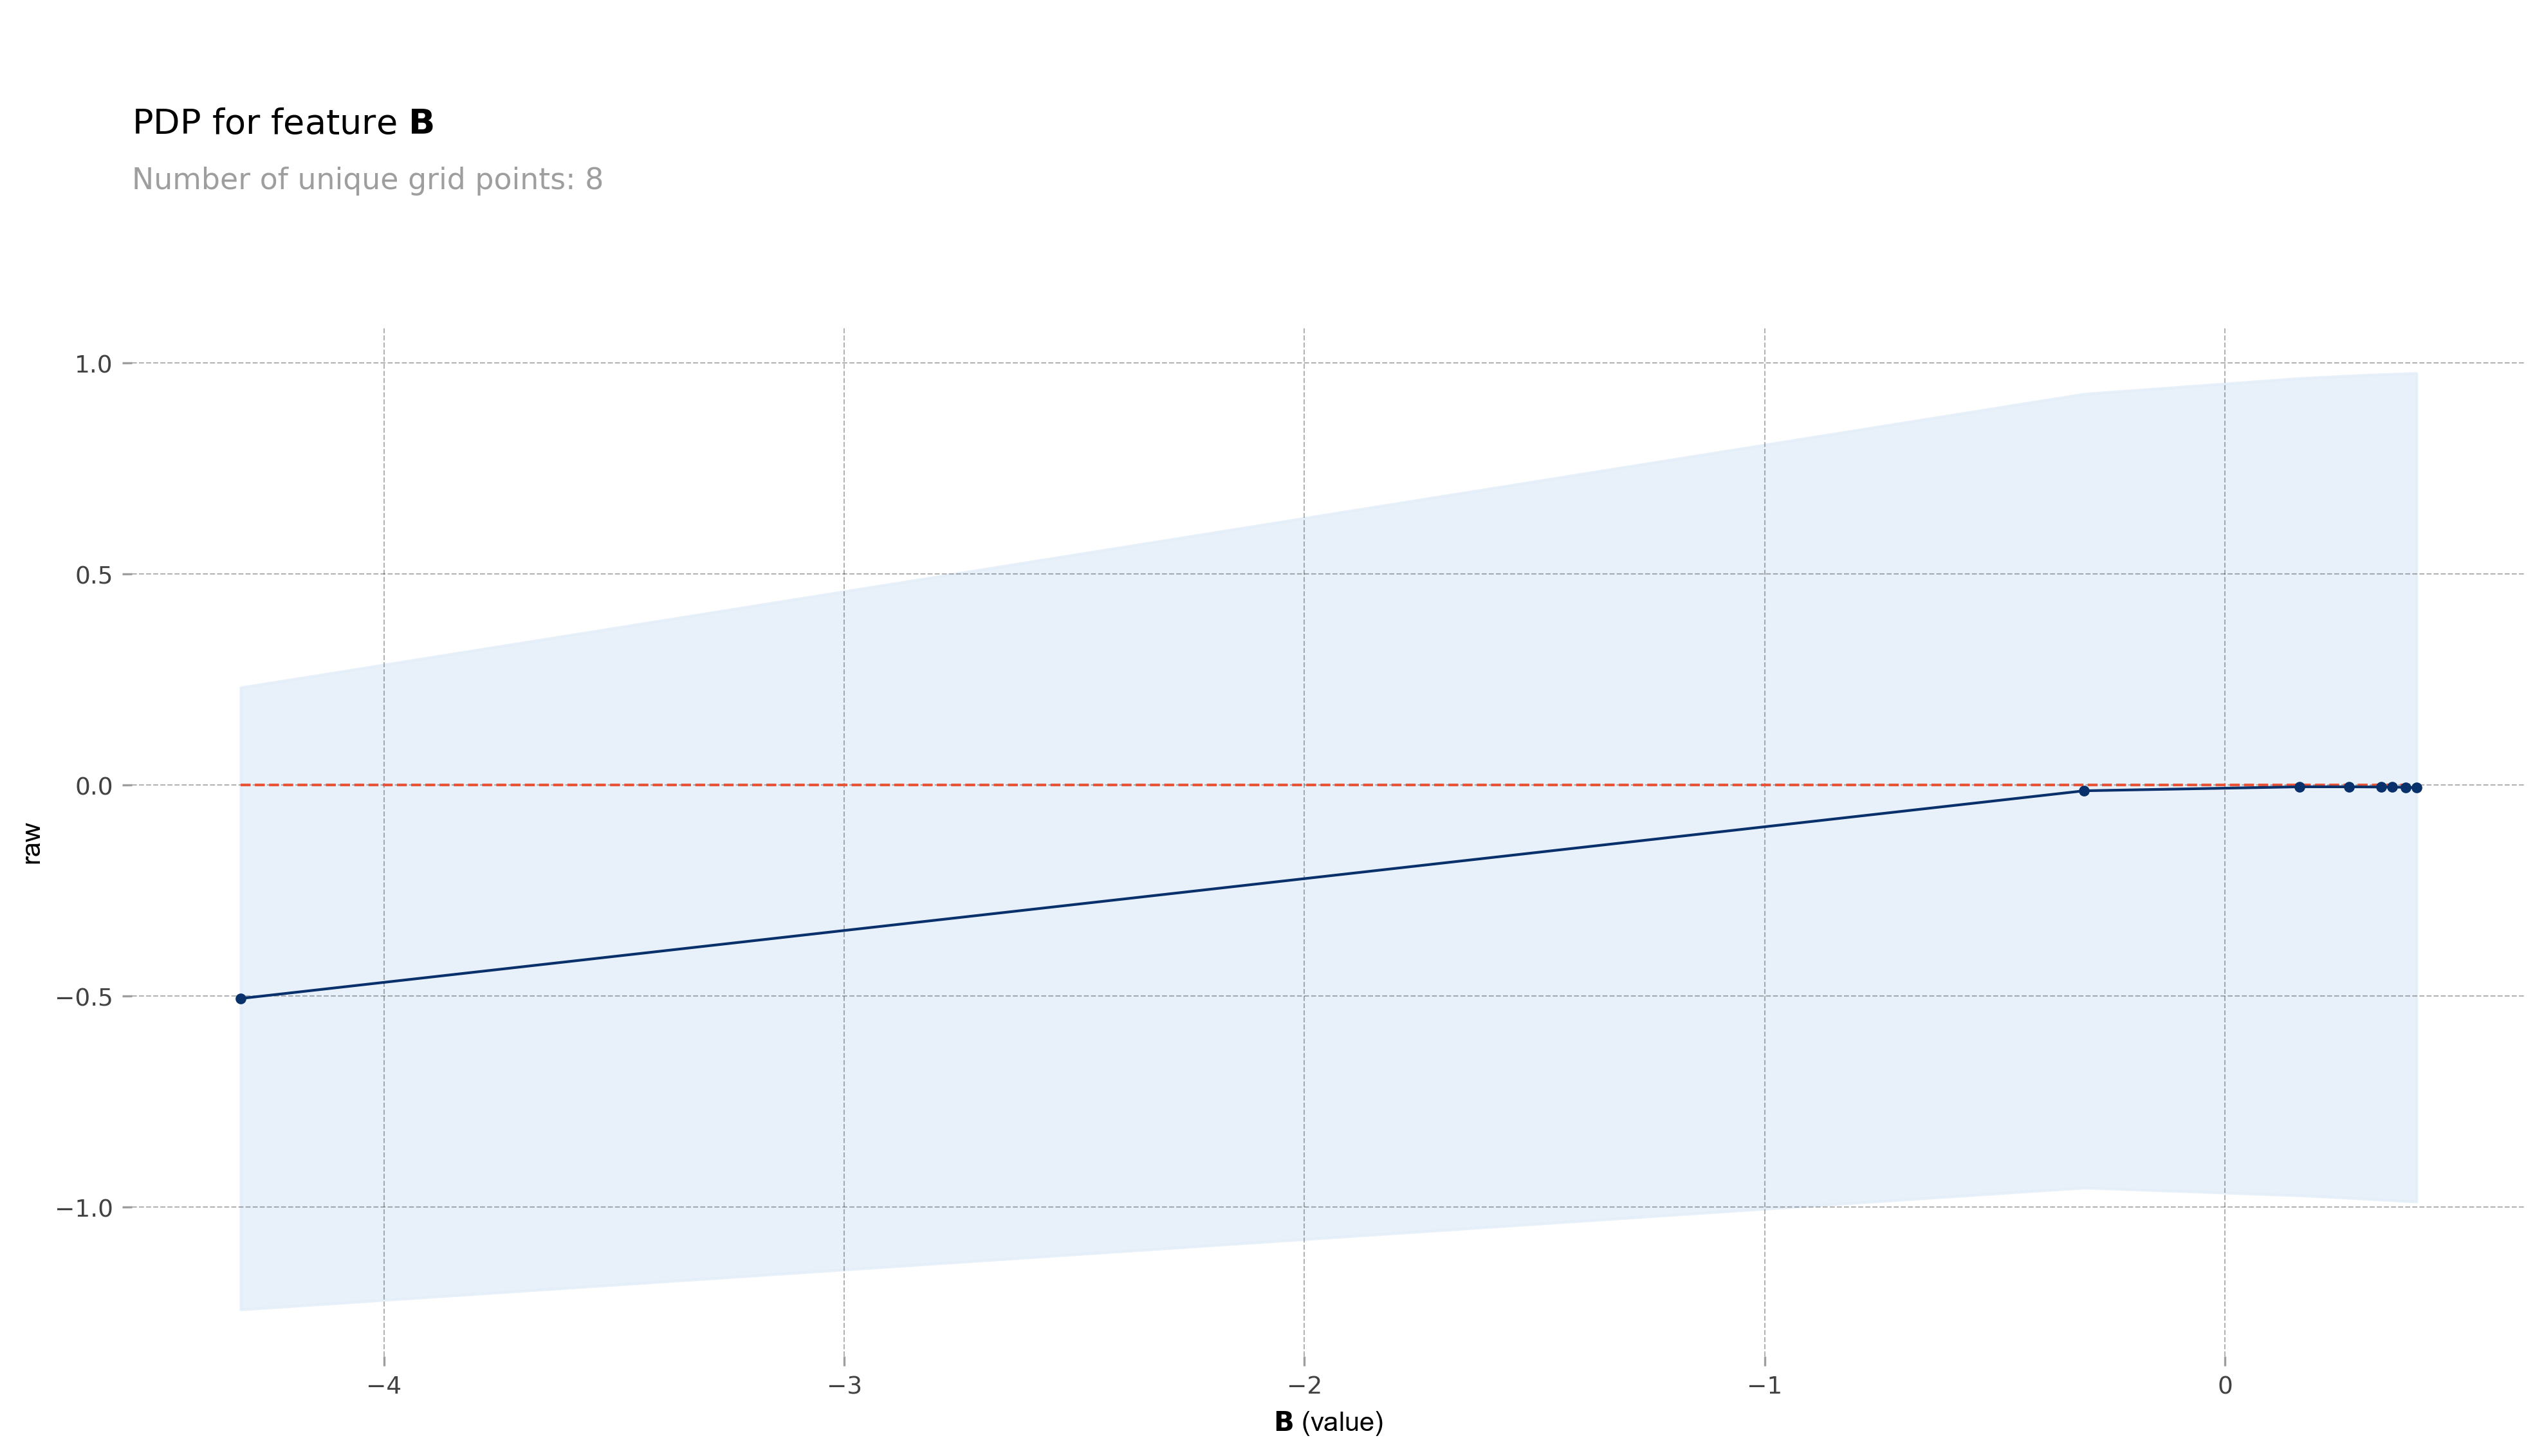

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 30%|███       | 3/10 [00:00<00:00, 28.94it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 60%|██████    | 6/10 [00:00<00:00, 28.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 90%|█████████ | 9/10 [00:00<00:00, 28.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


100%|██████████| 10/10 [00:00<00:00, 28.74it/s]


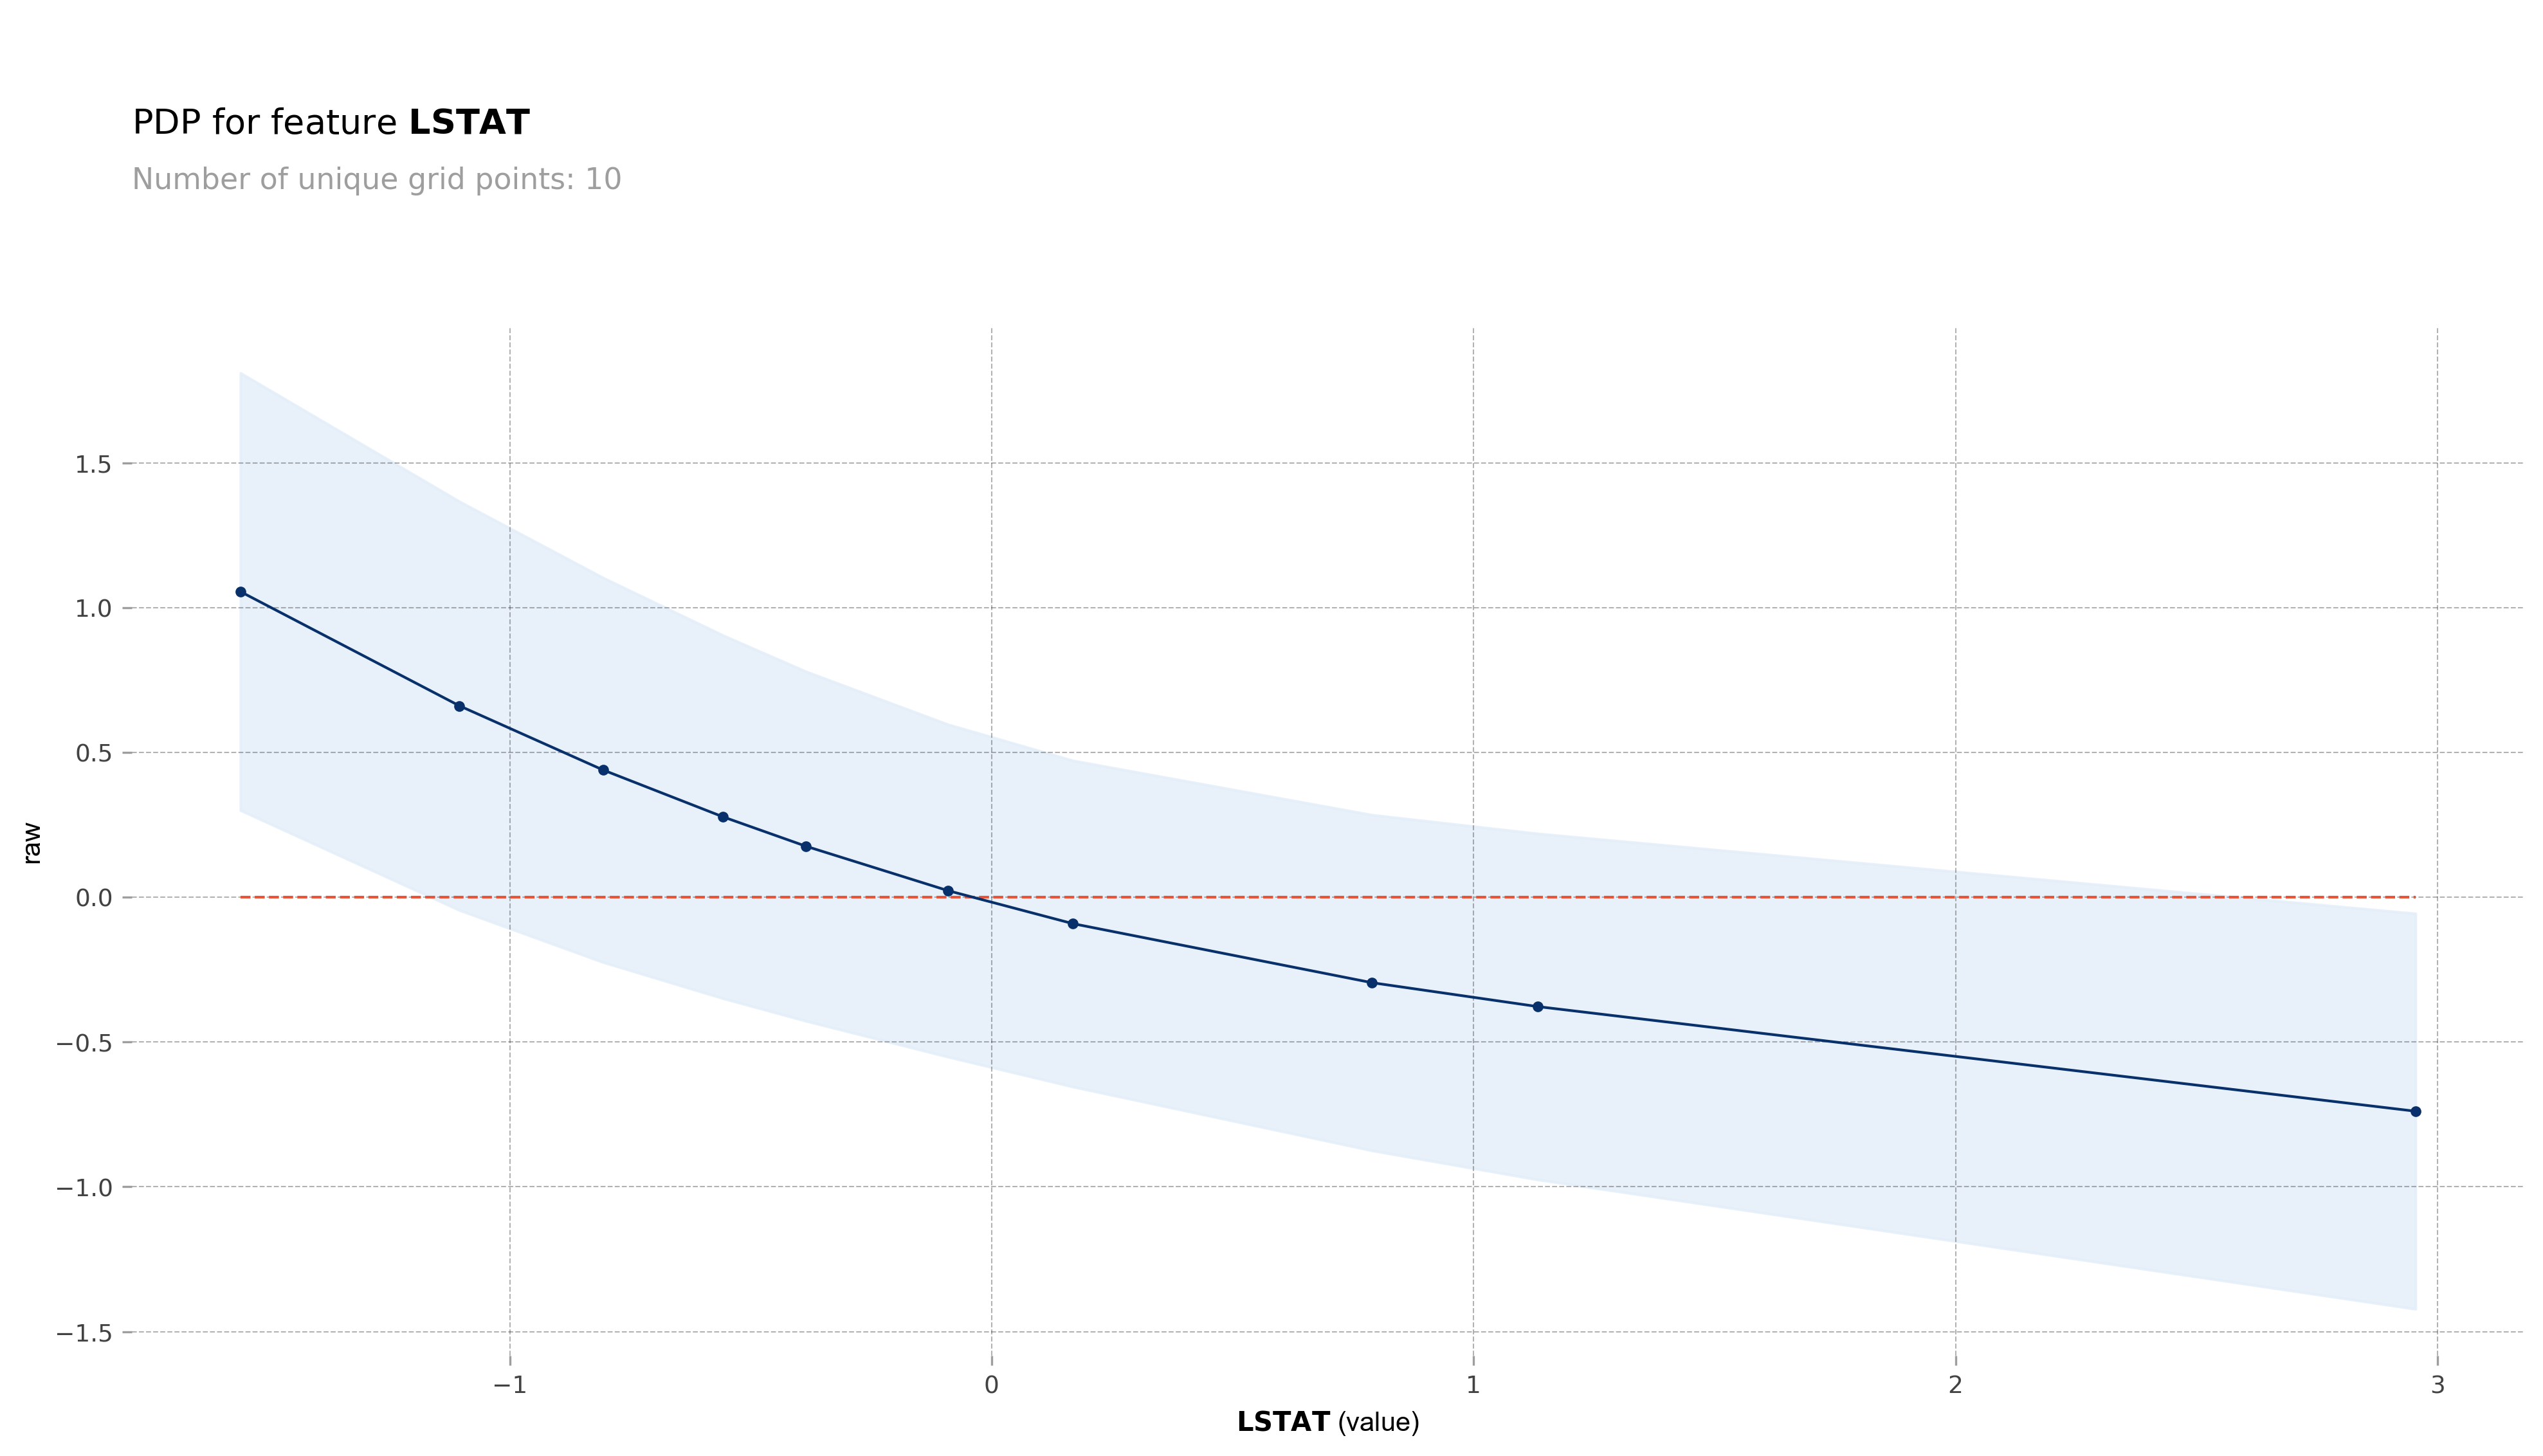

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 30%|███       | 3/10 [00:00<00:00, 28.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 70%|███████   | 7/10 [00:00<00:00, 30.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


100%|██████████| 10/10 [00:00<00:00, 26.34it/s]


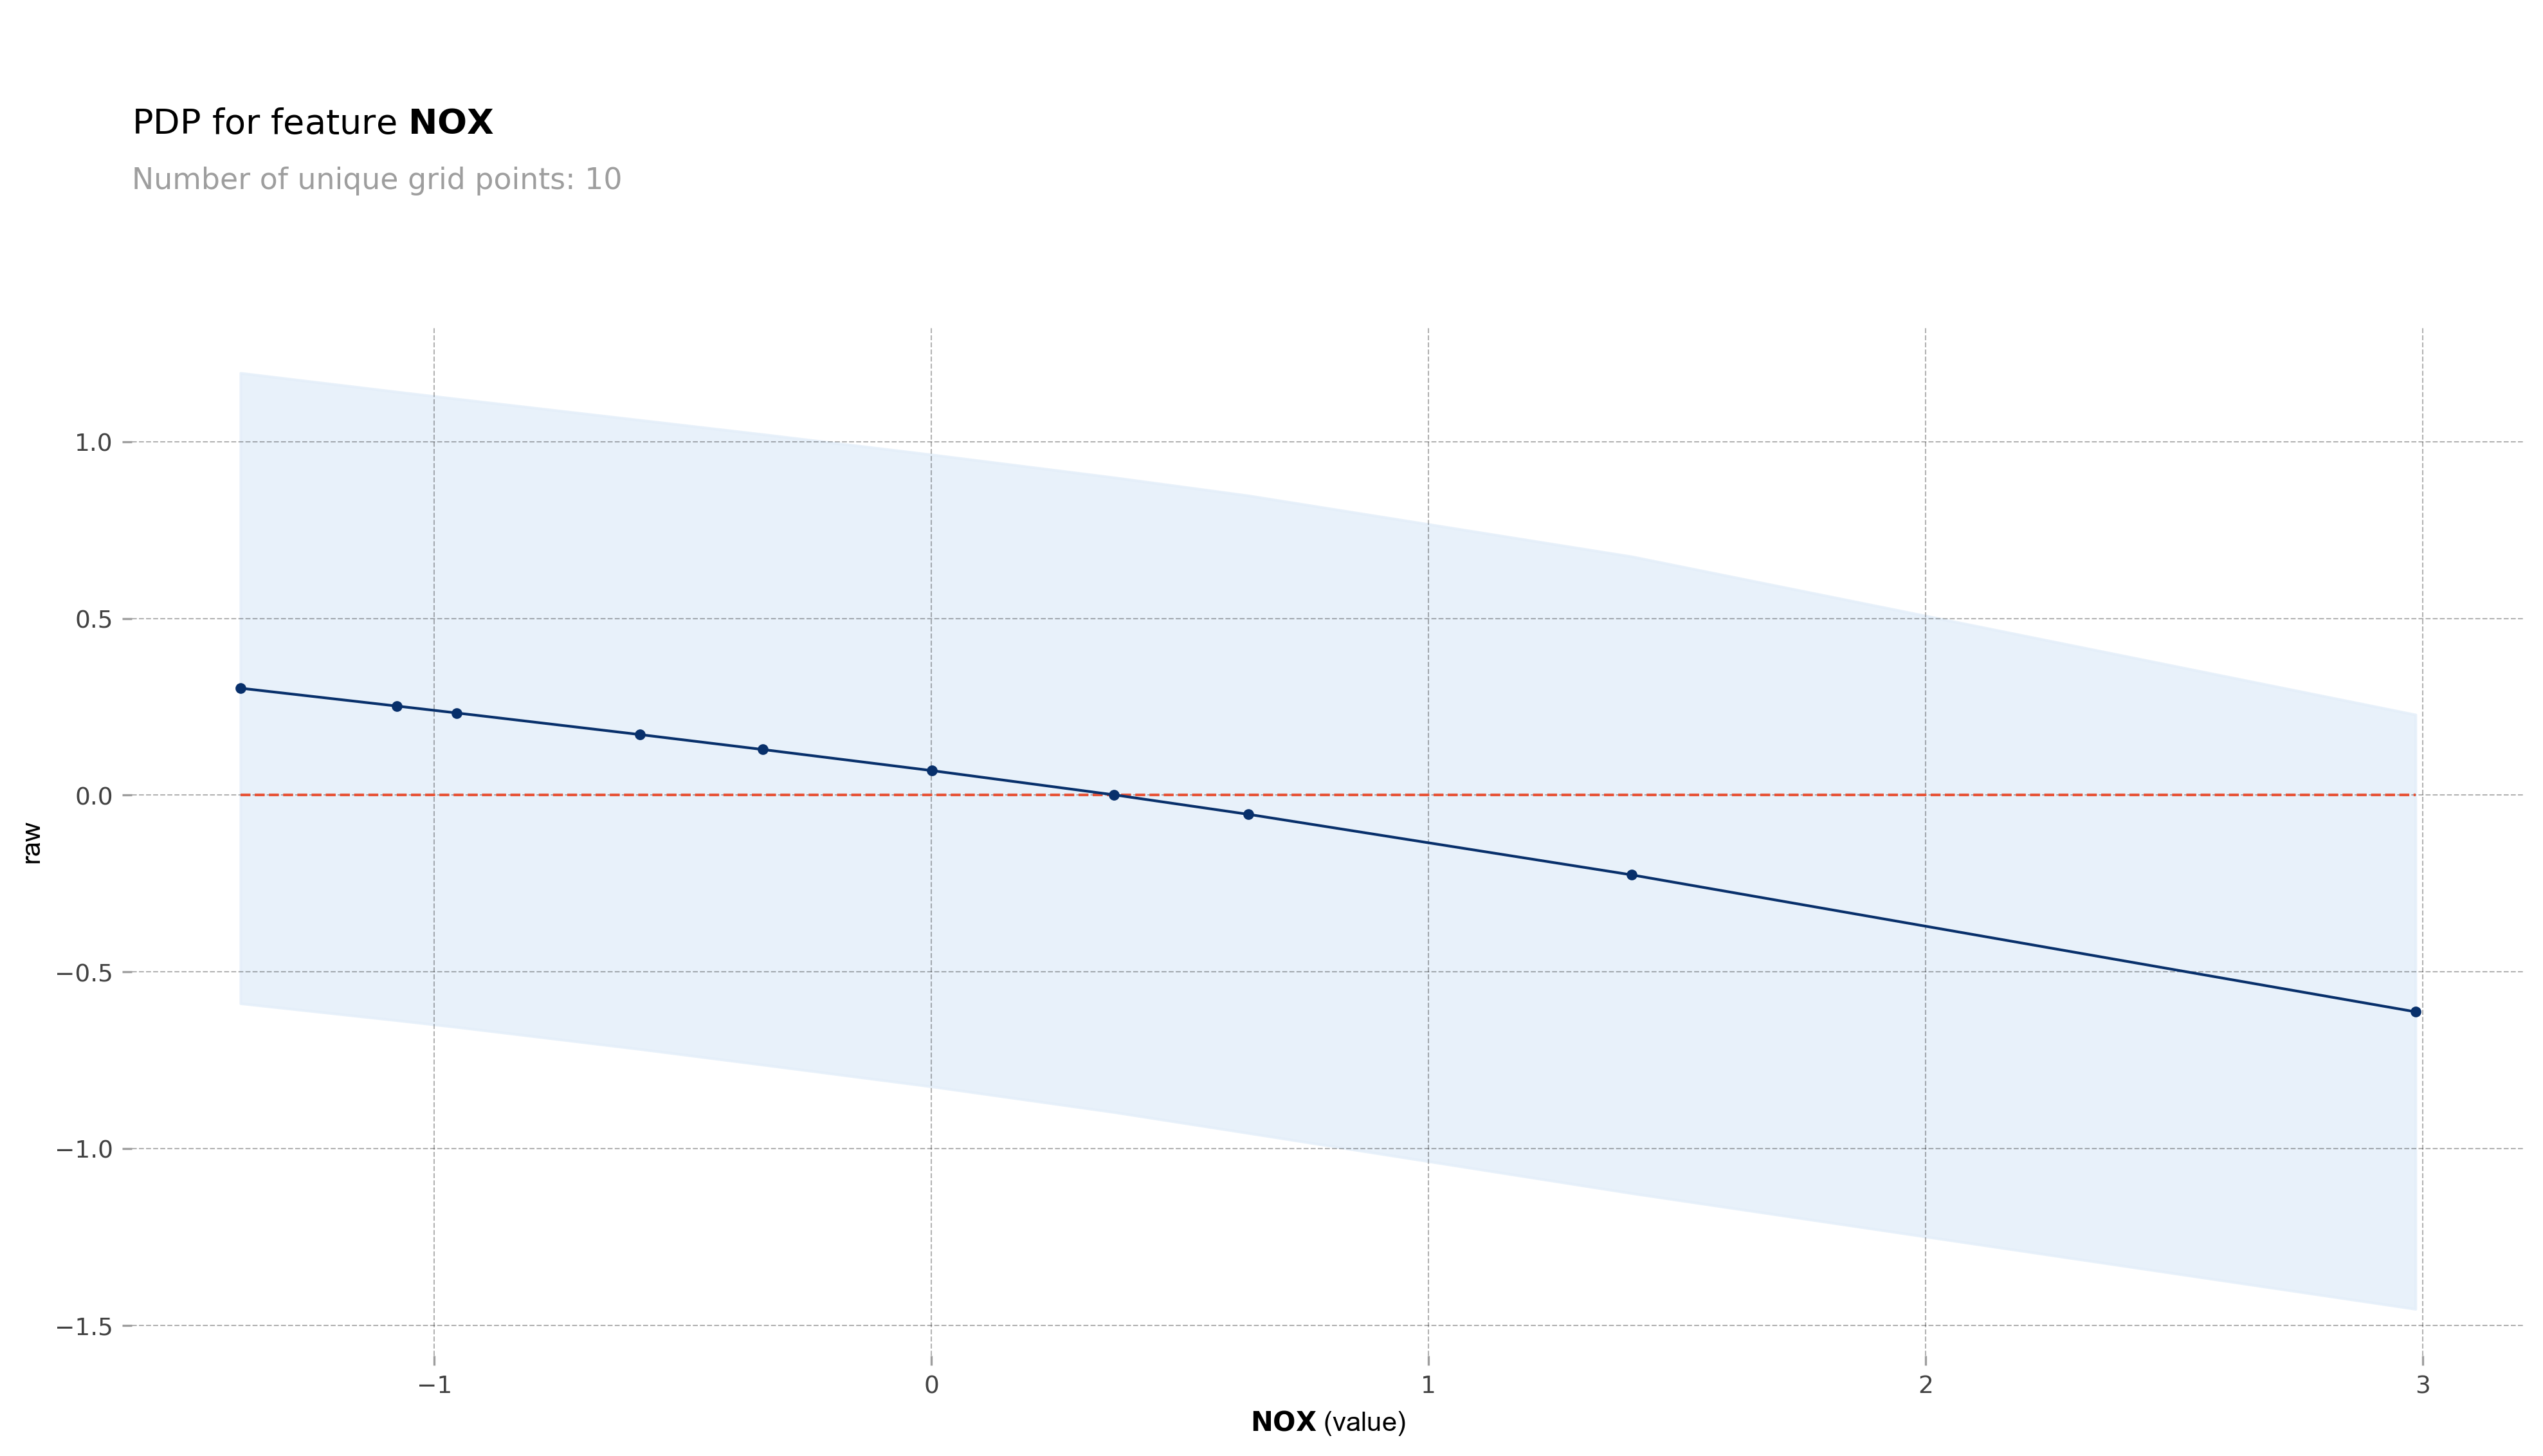

In [41]:
# Create PDPs for selected features
features_to_plot = ['B', 'LSTAT', 'NOX']

for i, feature in enumerate(features_to_plot):
    
    # Create the PDPBox isolate object
    pdp_isolate = pdp.PDPIsolate(
        model=boston_model,
        df=boston_test_df,
        model_features=boston_feature_names, 
        feature=feature,
        feature_name=feature,
        n_classes=0
    )
    
    # Plot the PDP
    fig, axes = pdp_isolate.plot(
        center=False,
        plot_lines=False,
        plot_pts_dist=False,
        to_bins=False,
        engine='matplotlib'
    )

    plt.tight_layout()
    plt.show()